# SQLite Practice - Answering Business Questions

In [3]:
2*4000/4 + 28 - 10

2018.0

## The Database

We are using a slighty modified version of the sample database, Chinook [¹](https://github.com/lerocha/chinook-database), to practice working with the sort of databases that most businesses will use. The Chinook database represents a digital music store containing information about the artists, songs, and albums.

## Project Goal

The aim of the project is to simulate the real world business usage of SQL. We will answer business questions of the like from finding the music genre that will sell the best to finding the effect of protected and non-protected media types on popularity.

## Setting Up the Environment

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3

## Creating Helper Functions

In [160]:
# returns a pandas dataframe of the runned query
def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)

In [161]:
# returns a list of all tables and views in the database
def show_tables():
    q = "SELECT\
             name,\
             type\
         FROM sqlite_master\
         WHERE type IN ('table','view')\
        "
    return run_query(q)

## Viewing the Database

In [162]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Top Selling Genre in the U.S

#### Hypothetical Business Scenario

The digital music store, Chinook, was given money by a record label to advertise new albums of emerging artists in the U.S. We only know the names of the artists and the genre of music they produce. The goal is to advertise albums that will sell the best in the U.S

In [163]:
# query to find top selling genre in the U.S
top_genre_q = """
    WITH 
        genre_track AS
            (
                SELECT
                    g.name genre,
                    t.track_id
                FROM genre g
                INNER JOIN track t 
                ON t.genre_id = g.genre_id
            ),
        genre_invoice AS
            (
                SELECT
                    gt.genre,
                    il.track_id,
                    il.invoice_id
                FROM invoice_line il
                INNER JOIN genre_track gt
                ON gt.track_id = il.track_id            
            ),
        top_genre AS
            (
                SELECT
                   gi.genre,
                   COUNT(gi.track_id) tracks_sold
                FROM genre_invoice gi
                INNER JOIN invoice i
                ON i.invoice_id = gi.invoice_id
                WHERE i.billing_country = 'USA'
                GROUP BY gi.genre
            )
            
    SELECT 
        *, 
        CAST(tracks_sold as FLOAT)/
        (SELECT SUM(tracks_sold) FROM top_genre) percentage_sold
    FROM top_genre
    ORDER BY tracks_sold DESC;
"""
top_genre_usa = run_query(top_genre_q)
top_genre_usa

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


### Visualization of Top Selling Genres

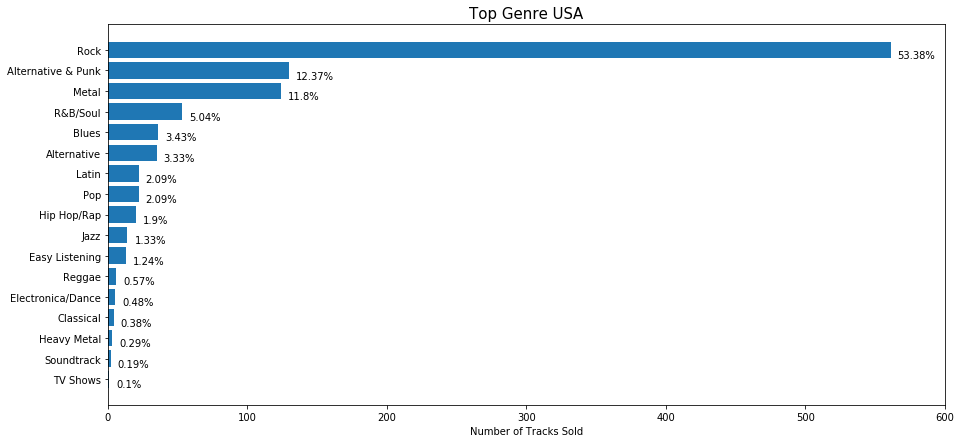

In [164]:
# the container and subplots
fig, ax = plt.subplots(figsize = (15,7))

# the y loc of the genre
y_loc = np.arange(len(top_genre_usa))

# plotting the barh graph
ax.barh(y = y_loc, 
        width = top_genre_usa["tracks_sold"]
       )

ax.set_title("Top Genre USA", fontsize = 15)
ax.set_xlabel("Number of Tracks Sold")

# labeling the barh
ax.set_yticks(y_loc)
ax.set_yticklabels(top_genre_usa["genre"])

# setting the boundary of x
ax.set_xlim(0,600)

# invert the barh graph so its descending
ax.invert_yaxis()

# ax.patches return the rect of each bar
rects = ax.patches
labels = [str(round(100 * num,2)) + "%" for num in top_genre_usa["percentage_sold"]]

# annotating the bar graph
for rect, label in zip(rects, labels) : 
    # the spacing of the annotation
    x_pos = rect.get_width() + 5
    y_pos = rect.get_y() + rect.get_height()
    
    ax.text(x_pos,y_pos, label)

Answering our hypothetical business question, we should prioritize advertising rock albums in the U.S and so on as we go down the list. Realistically however, Pop and Hip Hop/Rap would be the dominant genres if we were to be using a real digital music store database. 

## Sales Support Agent's Performance Analysis

In [165]:
# query to find total dollar amount of sales for each S.S.A
ssa_sale_q = """
        With
            customer_invoice AS
                (
                    SELECT
                        c.first_name ||" "|| c.last_name customer_name,
                        SUM(i.total) customer_total,
                        c.support_rep_id
                    FROM customer c
                    INNER JOIN invoice i
                    ON i.customer_id = c.customer_id
                    GROUP BY i.invoice_id
                ),
            employee_sale AS
                (
                    SELECT
                        e.first_name ||" "|| e.last_name employee,
                        e.title,
                        e.hire_date,
                        SUM(ci.customer_total) total_sale
                    FROM employee e
                    INNER JOIN customer_invoice ci
                    ON ci.support_rep_id = e.employee_id
                    GROUP BY employee
                )
        SELECT * FROM employee_sale;
"""
ssa_sale = run_query(ssa_sale_q)
ssa_sale

,employee,title,hire_date,total_sale
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


#### Visualization of Sales of S.S.A

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]), <a list of 9 Text xticklabel objects>)


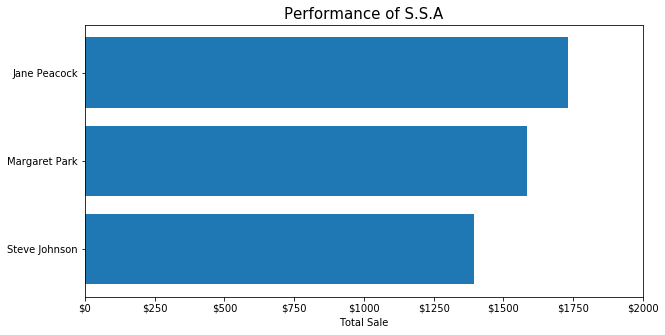

In [166]:
# the container and subplot
fig, ax = plt.subplots(figsize = (10,5))

# the y loc of employee
y_loc = np.arange(len(ssa_sale))

# the horizontal bar plot
ax.barh(y = y_loc,
        width = ssa_sale["total_sale"]
       )

# setting the boundary of x
ax.set_xlim(0,2000)

# sort bar graph in desc order
ax.invert_yaxis()

# label of each barh
ax.set_yticks(y_loc)
ax.set_yticklabels(ssa_sale["employee"])

# label of each x point
ax.set_xticklabels(["$" + str(sale) for sale in np.arange(0, 2001, 250)])

# setting the title of graph
ax.set_title("Performance of S.S.A", fontsize = 15)

# label of x axis
ax.set_xlabel("Total Sale")

print(plt.xticks())

We know that Jane Peacock has the most sales, but this doesn't necessarily mean Jane is the better sales support agent of the three. Out of the three, Jane happens to be the one with the most experience due to being hired first. Along with more experience, Jane has a head start in making sales giving her the number advantage. Instead of looking at the raw sale numbers, something like the customers' reviews of the interaction with the S.S.A would help us judge the performance of the S.S.A. There are also other factors like the type of sales the S.S.A is assisting with that needs to be accounted in this performance review.

## Sales By Country

#### Hypothetical Business Scenario

The Chinook marketing team needs us to find the country with the most potential for growth to advertise in. In other words, we need to find countries that will increase Chinook's sales in the long run.

In [167]:
# query to collect data on purchases from diff countries
country_sale_q = """
    WITH
        customer_invoice AS
            (
                SELECT
                    country,
                    i.invoice_id,
                    c.customer_id,
                    i.total customer_total
                FROM customer c
                INNER JOIN invoice i ON i.customer_id = c.customer_id
            ),
        country_sale AS
            (
                SELECT
                    ci.country,
                    CASE
                        WHEN COUNT(DISTINCT ci.customer_id) = 1
                        THEN "Other"
                        ELSE ci.country
                    END AS country_mod,
                    COUNT(DISTINCT customer_id) num_customer,
                    SUM(customer_total) total_sale
                FROM customer_invoice ci
                GROUP BY country
            ),
        total_country_bill AS
            (
                SELECT
                    cs.country_mod,
                    COUNT(DISTINCT customer_id) num_customer,
                    COUNT(DISTINCT ci.invoice_id) num_order,
                    cs.total_sale
                FROM customer_invoice ci
                INNER JOIN country_sale cs ON cs.country = ci.country
                INNER JOIN invoice_line il ON il.invoice_id = ci.invoice_id
                GROUP BY ci.country
            ),
        country_sale_stats AS
            (
                SELECT
                    country_mod country,
                    SUM(num_customer) num_customer,
                    SUM(total_sale) total_sale,
                    SUM(total_sale)/ SUM(num_order) avg_order_value,
                    SUM(total_sale)/ SUM(num_customer) avg_customer_sale
                FROM 
                    (
                        SELECT
                            *,
                            CASE
                                WHEN country_mod = "Other"
                                THEN 1
                                ELSE 0
                            END AS "order"
                        FROM total_country_bill
                    )
                GROUP BY country_mod
                ORDER BY "order", total_sale DESC
                
            )
    SELECT * FROM country_sale_stats   
"""
country_sale = run_query(country_sale_q)
country_sale

,country,num_customer,total_sale,avg_order_value,avg_customer_sale
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


#### Visualization of Sales by Countries

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

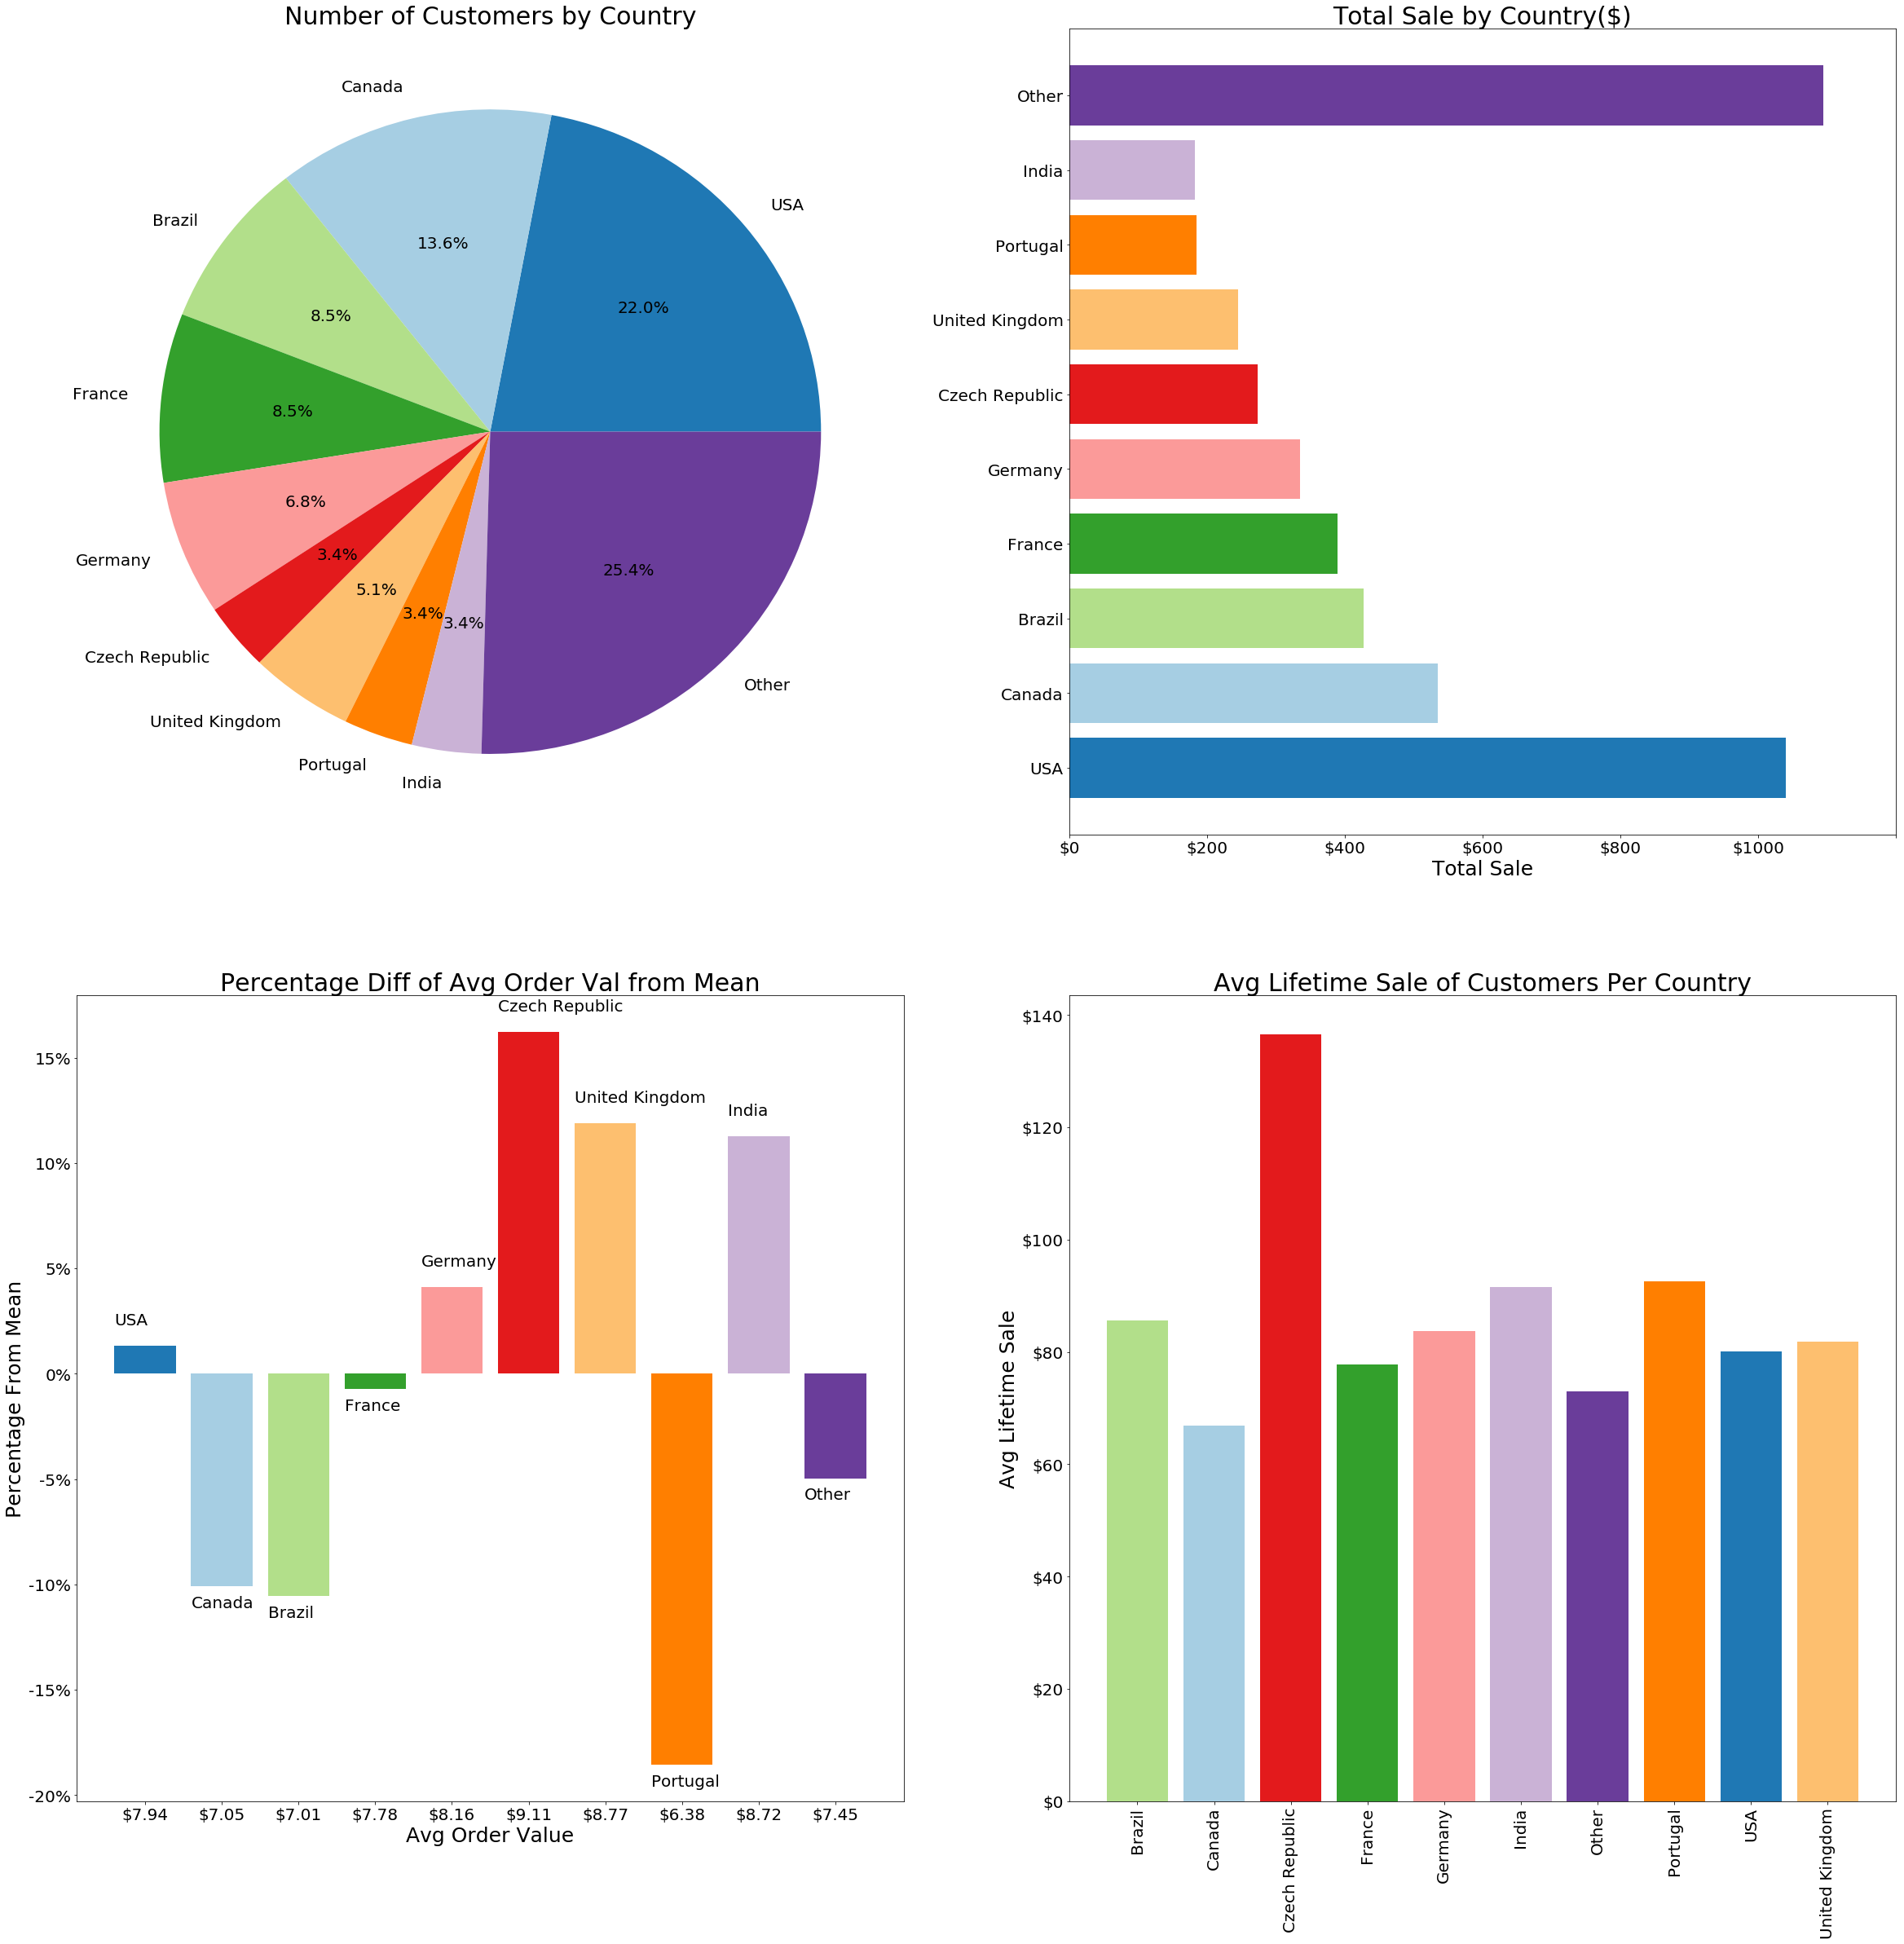

In [184]:
# creating figure and subplot
fig = plt.figure(figsize = (40,40))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# color to represent each country
colors = ["#1f78b4", "#a6cee3", "#b2df8a", "#33a02c", 
         "#fb9a99", "#e31a1c", "#fdbf6f",
         "#ff7f00", "#cab2d6", "#6a3d9a"]
countries = country_sale["country"] 



# pie chart for country - customer
sizes = country_sale["num_customer"] # num of customers

ax1.pie(sizes, labels = countries, 
        colors = colors, autopct='%1.1f%%', 
        textprops = {'fontsize':20})
ax1.set_title("Number of Customers by Country", fontsize = 30)



# bar graph for country - total sale
y_loc = np.arange(len(country_sale))
y = countries # all country except other
width = country_sale["total_sale"]

ax2.barh(y = y_loc, width = width,
         color = colors)
ax2.set_xlim(0,1200)
ax2.set_title("Total Sale by Country($)", fontsize = 30)

# setting the y value labels
ax2.set_yticks(y_loc)
ax2.set_yticklabels(countries, fontsize = 20)

ax2.set_xlabel("Total Sale", fontsize = 25)

# adding $ to the x value 
ax2.set_xticklabels((["$" + str(sale) for sale in np.arange(0,1200,200)]),
                    fontsize = 20)



# bar graph of diff from avg
mean_order_value = np.mean(country_sale["avg_order_value"])
diff_from_mean = country_sale["avg_order_value"] - mean_order_value
percent_from_mean = (diff_from_mean/mean_order_value) * 100

x_loc = np.arange(len(country_sale))
height = percent_from_mean

ax3.bar(x = x_loc, height = height,
        color = colors)
ax3.set_title("Percentage Diff of Avg Order Val from Mean", fontsize = 30)

# rounding the num of x values
ax3.set_xticks(x_loc)
ax3.set_xticklabels((["$" + str(round(n, 2)) for n in country_sale["avg_order_value"]]),
                    fontsize = 20)

# setting the x and y axis labels
ax3.set_ylabel("Percentage From Mean", fontsize = 25)
ax3.set_xlabel("Avg Order Value", fontsize = 25)

# adding % to value in y axis
ax3.set_yticklabels([str(value) + "%" for value in np.arange(-25,16, 5)],
                    fontsize = 20)

# ax.patches return the rect of each bar
rects = ax3.patches

# annotating the bar graph
for rect, label in zip(rects, countries) : 
    
    # the spacing of the annotation
    x_pos = rect.get_x()
    y_pos = rect.get_y() + rect.get_height() 
        
    if rect.get_height() < 0:
        y_pos -= 1
    else:
        y_pos += 1
    
    ax3.text(x_pos,y_pos, label, fontsize = 20)



# Average Lifetime Customer Sale by Country Bar Plot
ax4.bar(x = countries, height = country_sale["avg_customer_sale"],
        color = colors)
# adding dollar sign to y value
ax4.set_yticks(np.arange(0, 141, 20))
ax4.set_yticklabels(["$" + str(value) for value in np.arange(0, 141, 20)],
                    fontsize = 20)

# setting the y axis label
ax4.set_ylabel("Avg Lifetime Sale", fontsize = 25)

# setting the title of bar
ax4.set_title("Avg Lifetime Sale of Customers Per Country", fontsize = 30)

# setting the xtick label fontsize
plt.xticks(fontsize = 20, rotation = 90)

Other consist of countries with only one customer. Although other is included in the visualization, we will consider other as a outlier group. We can not judge the potential growth of Chinook in countries with only one customer. 

Even though the US is top in sales and makes up 22% of Chinook's customer, Czech Republic is the country with the highest potential for growth. Czech Republic average order value is 15% above the mean, and it has the highest average lifetime sale per customer. This means that the two customer that were from Czech Republic are probably very interested in the company as they spent on average the most compared to the other countries. 

However, we do not have enough information to dump all the company's advertisement money into Czech Republic. We can not say that the two customers from the country represent the interest of the whole country. We need to collect more data of each country like by doing surveys before making a solid conclusion.

## Albums vs Individual Tracks

In [169]:
# query to categorize invoices as album or individual track purchase 
album_or_track_q = """
    WITH
        invoice_track AS
            (
                SELECT
                    i.invoice_id,
                    il.track_id
                FROM invoice i
                INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
            ),
        bought_track AS
            (
                SELECT
                    it.invoice_id,
                    it.track_id,
                    t.album_id
                FROM invoice_track it
                INNER JOIN track t ON t.track_id = it.track_id
            ),
        album_track AS
            (
                SELECT
                  a.album_id,
                  t.track_id,
                  COUNT(a.album_id) num_tracks
                FROM album a
                INNER JOIN track t ON t.album_id = a.album_id
                GROUP BY a.album_id
            ),
        purchase_type AS
            (
                SELECT 
                    invoice_id,
                    album_id,
                    track_bought,
                    actual_track track_in_album,
                    kind_purchase
                FROM
                    (
                        SELECT
                            bt.invoice_id,
                            bt.album_id,
                            COUNT(bt.album_id) track_bought,
                            at.num_tracks actual_track,
                        CASE
                            WHEN 
                                 COUNT(DISTINCT bt.album_id) = 1 
                                 AND COUNT(bt.album_id) = at.num_tracks
                                 AND at.num_tracks > 2
                            THEN "album" 
                            ELSE "indiv. tracks"
                            END AS kind_purchase
                        FROM bought_track bt
                        INNER JOIN album_track at ON at.album_id = bt.album_id
                        GROUP BY bt.invoice_id, bt.album_id
                    )
            )
    SELECT
        kind_purchase,
        COUNT(num_purchase) num_purchase,
        100*(CAST(COUNT(num_purchase) as FLOAT)/ (SELECT COUNT(*) FROM invoice)) percentage_purchase
    FROM
        (
            SELECT
                kind_purchase,
                COUNT(kind_purchase) num_purchase
            FROM purchase_type
            GROUP BY invoice_id, kind_purchase
        )
    GROUP BY kind_purchase
    
"""
type_purchase = run_query(album_or_track_q)
type_purchase

,kind_purchase,num_purchase,percentage_purchase
0,album,111,18.078176
1,indiv. tracks,503,81.921824


#### Visualization of types of purchases

Text(0,0.5,'Num of Purchase')

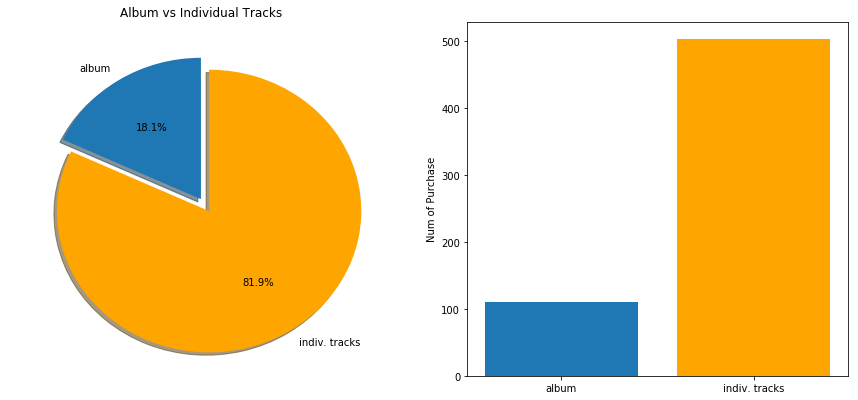

In [170]:
# creating the figure and subplot
fig = plt.figure(figsize = (15,6.5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# the two type of purchase
two_purchase = type_purchase["kind_purchase"]

# color to represent album/indiv track
colors = ["C0", "orange"]

# pie chart on percentage of album/indiv track
ax1.pie(x = type_purchase["percentage_purchase"], 
        labels = two_purchase,
        colors = colors,
        explode = (0,0.1),
        shadow = True,
        startangle = 90,
        autopct='%1.1f%%'
       )
# the title of pie chart
ax1.set_title("Album vs Individual Tracks", fontsize = 12)

# barh chart to represent the number of album/indiv track
ax2.bar(x = two_purchase, height = type_purchase["num_purchase"],
         color = colors
        )
# the y axis label
ax2.set_ylabel("Num of Purchase")

The digital music store is set up in a way in which customers can only purchase a single album or a collection of tracks. Our analysis shows that the majority of purchases are of individual tracks. Instead of buying albums and individual tracks from record labels, the store should use the money to purchase popular tracks from albums instead of buying whole albums. In doing so, the store will sell tracks that customers want and save money by not buying undesired tracks from albums.

However, Chinook might lose 18.1% of its total sale if Chinook decides to only sell popular tracks. It must find a way to satisfy both the majority and minority of their customers without losing too much of its total sale

## Top Artist by Playlist

In [171]:
top_artist_playlist_q = """
    WITH 
        playlist_track_mod AS 
            (
                SELECT 
                    p.name playlist_name,
                    p.playlist_id,
                    pt.track_id
                FROM playlist p 
                INNER JOIN playlist_track pt ON pt.playlist_id = p.playlist_id
            ),
        artist_track AS
            (
                SELECT 
                    art.name artist,
                    t.track_id
                FROM artist art
                INNER JOIN track t ON t.album_id = al.album_id
                INNER JOIN album al ON al.artist_id = art.artist_id
            ),
        playlist_artist AS
            (
                SELECT
                    pt.*,
                    at.artist
                FROM playlist_track_mod pt
                INNER JOIN artist_track at ON at.track_id = pt.track_id
            ),
        artist_in_playlist AS
            (
                SELECT
                    artist,
                    playlist_name,
                    playlist_id
                FROM playlist_artist
                GROUP BY artist, playlist_id
            )
            
SELECT 
    artist, 
    COUNT(artist) playlist_count
FROM artist_in_playlist
GROUP BY artist
ORDER BY playlist_count DESC
"""
top_artist_playlist = run_query(top_artist_playlist_q)
top_artist_playlist

,artist,playlist_count
0,Eugene Ormandy,7
1,Academy of St. Martin in the Fields & Sir Nevi...,6
2,Berliner Philharmoniker & Herbert Von Karajan,6
3,English Concert & Trevor Pinnock,6
4,The King's Singers,6
5,"Academy of St. Martin in the Fields, Sir Nevil...",5
6,Adrian Leaper & Doreen de Feis,5
7,Alberto Turco & Nova Schola Gregoriana,5
8,Antal Doráti & London Symphony Orchestra,5
9,Barry Wordsworth & BBC Concert Orchestra,5


In [172]:
# all playlist 
playlist_q = """
    SELECT DISTINCT name
    FROM playlist
"""
run_query(playlist_q)

,name
0,Music
1,Movies
2,TV Shows
3,Audiobooks
4,90’s Music
5,Music Videos
6,Brazilian Music
7,Classical
8,Classical 101 - Deep Cuts
9,Classical 101 - Next Steps


### Visualization

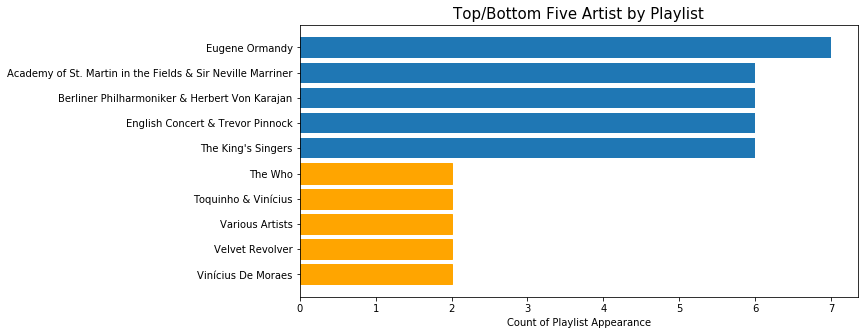

In [173]:
# the top artist 
top_five_artist = top_artist_playlist.head()
bottom_five_artist = top_artist_playlist.tail()
top_bottom_artist = pd.concat([top_five_artist, bottom_five_artist])

# the container and subplot
fig, ax = plt.subplots(figsize = (10,5))

# the y loc of each artist
y_loc = np.arange(len(top_bottom_artist))

# the barh graph
ax.barh(y = y_loc, 
        width = top_bottom_artist["playlist_count"],
        label = True)

# setting the color of bottom five artist
for bar in ax.get_children()[5:10]:
    bar.set_color("orange")

# title of barh
ax.set_title("Top/Bottom Five Artist by Playlist", fontsize = 15)

# the x axis label
ax.set_xlabel("Count of Playlist Appearance")

# setting the y value label
ax.set_yticks(y_loc)
ax.set_yticklabels(top_bottom_artist["artist"])

# sorting the barh from top-bottom
ax.invert_yaxis()

The top five and bottom five artists produce predominantly classical and rock music. We found the top and bottom artists by counting the number of playlist their music are in. It's important to note that the number of an artist's music in a playlist didn't matter. If an artist's work is in a playlist, we would the artist a plus one in the popular count. 

Because of how the popularity of an artist was decided, the types of playlist greatly influence an artist's popularity. Judging from the graph above, there is an significant amount of playlists that classical and rock could be in. If there are more playlist that favors Hip-Hop and Pop, artists who specialize in those genres will be more popular. We will use a more conventional and a more accurate way of calculating an artist popularity in analysis below.

## Top Artist by Sale

In [174]:
top_artist_by_sale_q = """
    WITH
        artist_track AS
            (
                SELECT
                    a.name artist,
                    t.track_id
                FROM artist a
                INNER JOIN track t ON t.album_id = al.album_id
                INNER JOIN album al ON al.artist_id = a.artist_id   
            ),
        track_line AS
            (
                SELECT
                    at.*,
                    il.unit_price * il.quantity sale
                FROM invoice_line il
                INNER JOIN artist_track at ON il.track_id = at.track_id
            ),
        artist_sale AS
            (
                SELECT
                    artist,
                    SUM(sale) total_sale
                FROM track_line
                GROUP BY artist
                ORDER BY total_sale DESC
            )
    SELECT * FROM artist_sale
"""
top_artist_sale = run_query(top_artist_by_sale_q)
top_artist_sale

,artist,total_sale
0,Queen,190.08
1,Jimi Hendrix,185.13
2,Nirvana,128.70
3,Red Hot Chili Peppers,128.70
4,Pearl Jam,127.71
5,AC/DC,122.76
6,Guns N' Roses,122.76
7,Foo Fighters,119.79
8,The Rolling Stones,115.83
9,Metallica,104.94


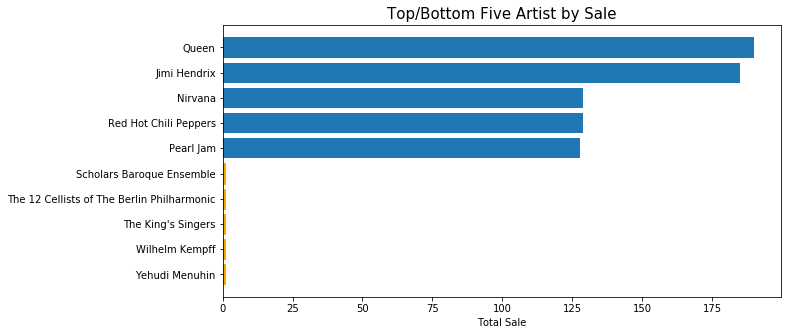

In [175]:
# the top artist 
top_five_artist = top_artist_sale.head()
bottom_five_artist = top_artist_sale.tail()
top_bottom_artist = pd.concat([top_five_artist, bottom_five_artist])

# the container and subplot
fig, ax = plt.subplots(figsize = (10,5))

# the y loc of each artist
y_loc = np.arange(len(top_bottom_artist))

# the barh graph
ax.barh(y = y_loc, 
        width = top_bottom_artist["total_sale"],
        label = True)

# setting the color of bottom five artist
for bar in ax.get_children()[5:10]:
    bar.set_color("orange")

# title of barh
ax.set_title("Top/Bottom Five Artist by Sale", fontsize = 15)

# the x axis label
ax.set_xlabel("Total Sale")

# setting the y value label
ax.set_yticks(y_loc)
ax.set_yticklabels(top_bottom_artist["artist"])

# sorting the barh from top-bottom
ax.invert_yaxis()

As you can see, the results we get by using the total sale to determine popular artists are polar opposites of the popular artist we got by using the number of playlists they are in. Even if we didn't know that the types of playlist affects the popularity of an artist, we know that having mostly classical music artists in the top five seems off especially in our day and age. Using total sales, we get a more appropriate answer from the analysis.

## Protected vs Non-Protected Media Type

In [176]:
media_type_q = """
    WITH
        media_track AS
            (
                SELECT 
                    m.name media_type,
                    t.track_id
                FROM media_type m
                INNER JOIN track t ON t.media_type_id = m.media_type_id
            ),
        track_invoice AS
            (
                SELECT
                    mt.media_type,
                    il.invoice_id,
                    il.unit_price,
                    il.quantity
                FROM media_track mt
                INNER JOIN invoice_line il ON il.track_id = mt.track_id
            ),
        popularity AS
            (
                SELECT
                    media_type,
                    SUM(quantity) total_order,
                    SUM(quantity * unit_price) total_sale
                FROM track_invoice
                GROUP BY media_type
            )
SELECT * FROM popularity
"""
media_type_compare = run_query(media_type_q)
media_type_compare

,media_type,total_order,total_sale
0,AAC audio file,21,20.79
1,MPEG audio file,4259,4216.41
2,Protected AAC audio file,439,434.61
3,Protected MPEG-4 video file,3,2.97
4,Purchased AAC audio file,35,34.65


In [177]:
# adding a protected type check column
protected_check = ["No" if "Protected" not in media_type else "Yes" for media_type in media_type_compare.iloc[:,0]]
media_type_compare.insert(loc = 1,
                          column = "protected_type",
                          value = protected_check
                         )
media_type_compare = media_type_compare.sort_values(by = ["total_order"], ascending = False)
media_type_compare

,media_type,protected_type,total_order,total_sale
1,MPEG audio file,No,4259,4216.41
2,Protected AAC audio file,Yes,439,434.61
4,Purchased AAC audio file,No,35,34.65
0,AAC audio file,No,21,20.79
3,Protected MPEG-4 video file,Yes,3,2.97


In [229]:
# a table comparing protected and non protected
protected_vs_non = media_type_compare.groupby('protected_type')
protected_vs_non = protected_vs_non.agg(sum)
protected_vs_non

,total_order,total_sale
protected_type,,
No,4315,4271.85
Yes,442,437.58


### Visualization

Text(0.5,1,'Total Sale')

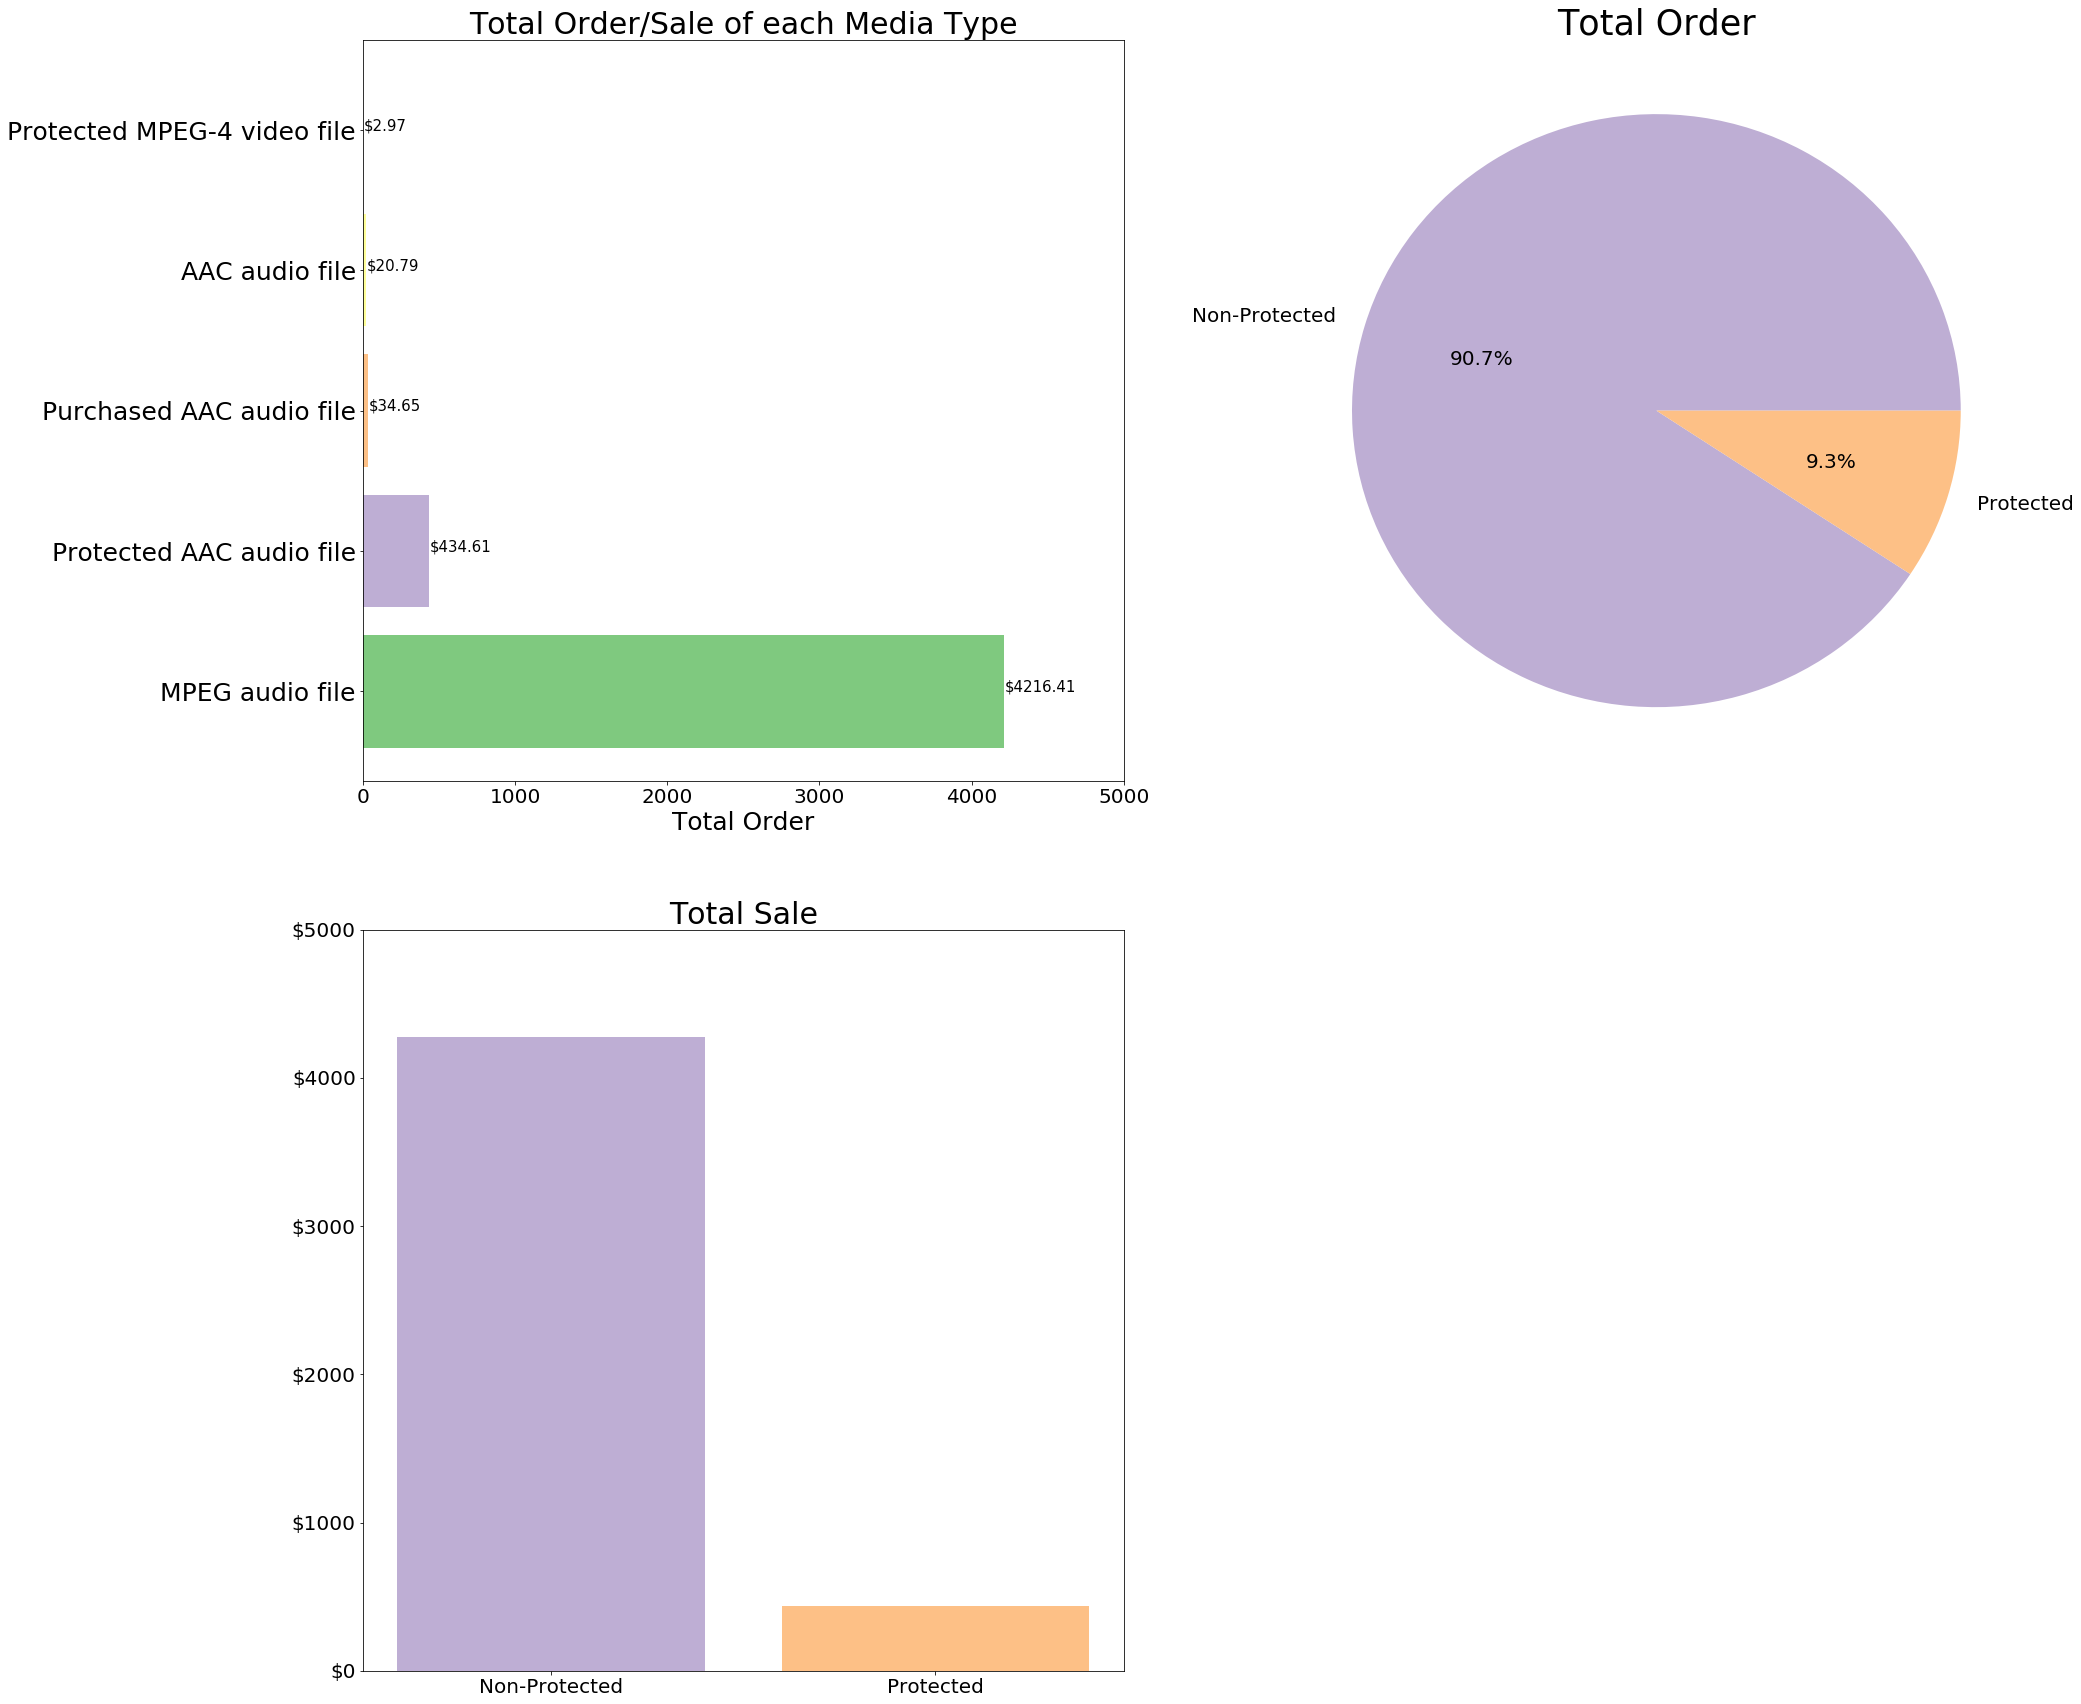

In [235]:
# creating the fig and subplot
fig = plt.figure(figsize = (30,30))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

media_type = media_type_compare["media_type"]
total_order = media_type_compare["total_order"]
total_sale = media_type_compare["total_sale"]

protected_total_order = protected_vs_non["total_order"]
protected_total_sale = protected_vs_non["total_sale"]

media_color = ["#7fc97f", "#beaed4", "#fdc086",
               "#ffff99", "#386cb0"]
protected_color = ["#beaed4","#fdc086"]

# y loc of y values
y_loc = np.arange(len(media_type))

# the pie chart of media_type
ax1.barh(y = y_loc, width = total_sale, color = media_color)

# the x value limit
ax1.set_xlim(0, 5000)

# setting the tick label
ax1.set_yticks(y_loc)
ax1.set_yticklabels(media_type, fontsize = 25)
ax1.set_xticklabels(np.arange(0,6000,1000), fontsize = 20)

# ax1.patches return the rect of each bar
rects = ax1.patches
labels = ["$" + str(round(v,2)) for v in total_sale]

# annotating the bar graph
for rect, label in zip(rects, labels) : 
    # the spacing of the annotation
    x_pos = rect.get_width() + 5
    y_pos = rect.get_y() + rect.get_height()/2
    
    ax1.text(x_pos,y_pos, label, fontsize = 15)


# the title of bar graph
ax1.set_title("Total Order/Sale of each Media Type", fontsize = 30)

# the x axis label
ax1.set_xlabel("Total Order", fontsize = 25)

# the pie chart for protected and non protected
ax2.pie(x = protected_total_order, 
        labels = ["Non-Protected", "Protected"],
        colors = protected_color, 
        autopct ='%1.1f%%', 
        textprops = {'fontsize':20})

# the title of pie chart
ax2.set_title("Total Order",
              fontsize = 35)

# bar graph to compare total sale of protected and non
ax3.bar(x = ["Non-Protected", "Protected"],
        height = protected_total_sale,
        color = protected_color)

# the y tick label
ax3.set_yticks(np.arange(0,6000,1000))
ax3.set_yticklabels(["$" + str(v) for v in np.arange(0,6000,1000)], fontsize = 20)

# the x tick label
ax3.set_xticklabels(["Non-Protected", "Protected"], fontsize = 20)

# the title 
ax3.set_title("Total Sale", fontsize = 30)


A protected media file is a file that can only be played on an authorized account that it was bought on. Whereas a non-protected media can be transfered to another account to be played on. Having a protected media prevents a person from sharing the media with someone else, so there is more of an incentive to purchase songs that are non-protected because there's no restriction on what you can do with them.